# Convolutional Neural Networks

## Preliminaries

In this practical session you will implement and train several Convolutional Neural Networks (CNNs) using the Keras framework with a Tensorflow backend. If you are not already familiar with Keras, you can go over the [following tutorial](https://github.com/tueimage/essential-skills/blob/master/keras.md). More detailed information on the different functionalities can be found in the [Keras library documentation](https://keras.io/). 

Note that for this set of exercise CPU-only Tensorflow, which you should already have installed, is sufficient (i.e. GPU-support is not required but it will make your experiments run faster). 

You are also required to use the `gryds` package for data augmentation that you can install directly from git: `pip install git+https://github.com/tueimage/gryds/`.

You also have to install the Keras deep learning framework (if you have not done so already) by running `conda install keras`. Note that there are two implementations of Keras, one from https://keras.io/ and another one that ships with Tensorflow. Here we use the former. 

## MNIST
We will first train a simple CNN to classify handwritten digits using the MNIST dataset. This dataset is often referred to as the "Hello world!" example of deep learning because it can be used to quickly illustrate a small neural network in action (and obtain a decent classification accuracy in the process). More information on it can be found [here](http://yann.lecun.com/exdb/mnist/).

First, let's load the dataset and visualize some images.

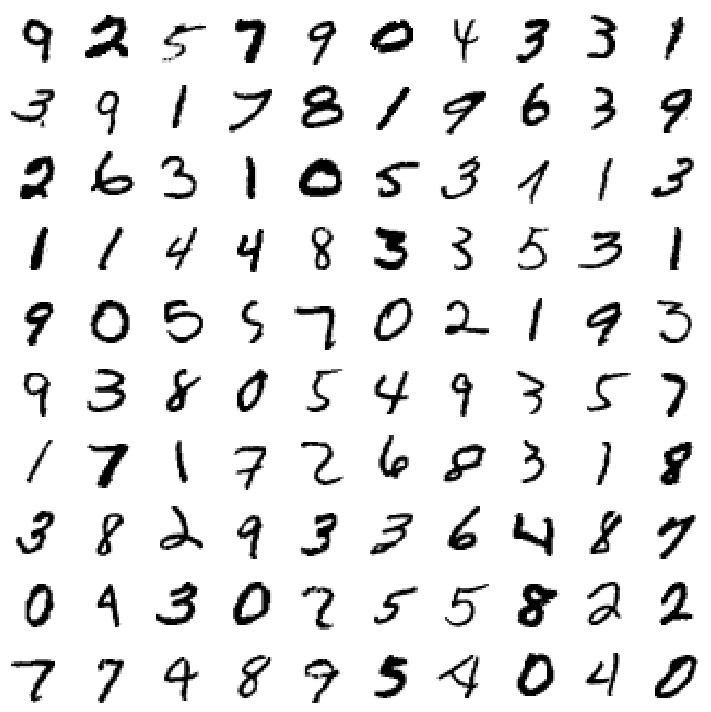

In [4]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

# from keras datasets open mnist
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical

# load the MNIST the dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# scale the image intensities to the 0-1 range
x_train = (x_train / 255.0).astype(np.float32)
x_test = (x_test / 255.0).astype(np.float32)

# convert the data to channel-last
x_train = np.expand_dims(x_train, axis=-1)
x_test = np.expand_dims(x_test, axis=-1)

# convert the labels to one-hot encoded
y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)

def plot_images(images, dim=(10, 10), figsize=(10, 10), title=''):
    
    plt.figure(figsize=figsize)
    
    for i in range(images.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(images[i], interpolation='nearest', cmap='gray_r')
        plt.axis('off')
    
    plt.tight_layout()
    plt.suptitle(title)
    plt.show()
    
plot_images(x_train[np.random.randint(0, x_train.shape[0], size=100)].reshape(100, 28, 28))

The MNIST classification task is quite simple: given an image, predict the digit that it contains. Thus, this is a 10-class classification problem.

Let's define a simple network for the handwritten digit classification.

In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense

model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               1179776   
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)              

Compile and train the network (note that this could take a while).

In [6]:
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adam

model.compile(loss=categorical_crossentropy, optimizer=Adam(), metrics=['accuracy'])

model.fit(x_train, y_train,
          batch_size=128,
          epochs=12,
          verbose=1,
          validation_data=(x_test, y_test))

score = model.evaluate(x_test, y_test, verbose=0)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

Epoch 1/12
469/469 [==============================] - 22s 34ms/step - loss: 0.4731 - accuracy: 0.8520 - val_loss: 0.0553 - val_accuracy: 0.9820
Epoch 2/12
469/469 [==============================] - 15s 32ms/step - loss: 0.0876 - accuracy: 0.9733 - val_loss: 0.0370 - val_accuracy: 0.9878
Epoch 3/12
469/469 [==============================] - 15s 32ms/step - loss: 0.0627 - accuracy: 0.9801 - val_loss: 0.0363 - val_accuracy: 0.98850 
Epoch 4/12
469/469 [==============================] - 15s 32ms/step - loss: 0.0488 - accuracy: 0.9847 - val_loss: 0.0289 - val_accuracy: 0.9906 - loss: 0.0487 - accuracy: 
Epoch 5/12
469/469 [==============================] - 15s 33ms/step - loss: 0.0413 - accuracy: 0.9865 - val_loss: 0.0273 - val_accuracy: 0.9915
Epoch 6/12
469/469 [==============================] - 15s 33ms/step - loss: 0.0392 - accuracy: 0.9886 - val_loss: 0.0294 - val_accuracy: 0.9908
Epoch 7/12
469/469 [==============================] - 15s 32ms/step - loss: 0.0313 - accuracy: 0.9899 - va

Now that the model is trained, we can evaluate its performance on the independent test dataset.

In [7]:
score = model.evaluate(x_test, y_test, verbose=0)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.030440328642725945
Test accuracy: 0.9916999936103821


## U-Net
The U-Net convolutional neural network architecture was first developed for biomedical image segmentation and is to this day one of the most widely used methods for image segmentation. The details of the architecture can be found in the [original paper](https://arxiv.org/abs/1505.04597). In this practical we will build and train a U-Net network that is able to segment blood vessels in retinal images. 

### Loading and visualizing the data
The data for this task is taken from the [DRIVE](https://www.isi.uu.nl/Research/Databases/DRIVE/index.php) database. It consists of photographs of the retina, where the goal is to segment the blood vessels within. The dataset has a total of 40 photographs, divided in 20 images for training and 20 for testing. The images corresponding to the DRIVE test set can be found [here](https://www.dropbox.com/s/zk51wgupimw7jd9/DRIVE.zip?dl=0).

Let's load the training set and visualize an image with the corresponding blood vessel segmentation. For training we will divide the data in a training and a validation set to monitor the model during training.

Got 20 images, 20 masks, 20 segmentations
(20, 584, 565, 3)


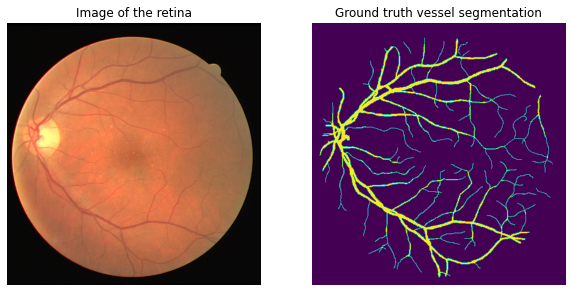

(16, 584, 565, 3)
(16, 584, 565, 1)
(16, 584, 565, 1)
(4, 584, 565, 3)
(4, 584, 565, 1)
(4, 584, 565, 1)


In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from glob import glob

import os
import sys

sys.path.append('code/')
from unet_utils import load_data

# location of the DRIVE dataset
data_folder = '../practicals/data/week5/'
train_paths = glob(data_folder + 'training/images/*.tif')
images, masks, segmentations = load_data(train_paths)

print(f'Got {len(images)} images, {len(masks)} masks, {len(segmentations)} segmentations')

# print the shape of image dataset
print(images.shape)

plt.figure(figsize=(10, 8))

plt.subplot(1, 2, 1)
plt.title("Image of the retina")
plt.axis('off')
plt.imshow(images[0])

plt.subplot(1, 2, 2)
plt.title("Ground truth vessel segmentation")
plt.axis('off')
plt.imshow(segmentations[0][:, :, 0])

plt.show()

# divide in training and validation
train_images, val_images, train_masks, val_masks, train_segmentations, val_segmentations = train_test_split(
    images, masks, segmentations, test_size=0.2, random_state=7)

# print the shape of the training and valudation datasets
print(train_images.shape)
print(train_masks.shape)
print(train_segmentations.shape)
print(val_images.shape)
print(val_masks.shape)
print(val_segmentations.shape)

### Training a U-Net model

You are already provided with implementation of the U-Net architecture in `unet_model.py`. This is a modular implementation and can be used to generate U-Net architectures with a variety of hyperparameters such as depth and number of feature maps. Before using the model, examine the code and documentation and make sure that you understand all the details.

We will train a U-Net model using smaller patches extracted from the training images. Training the images on smaller patches requires less computation power and results in a more varied training dataset (it has the effect of data augmentation by image translation). Because a U-Net is a fully convolutional network it can be evaluated on inputs of different size (the output size will change according to the input size). Thus, although the model will be trained on smaller patches it can still be used to segment larger images with one pass through the model. 


(16, 32, 32, 3)


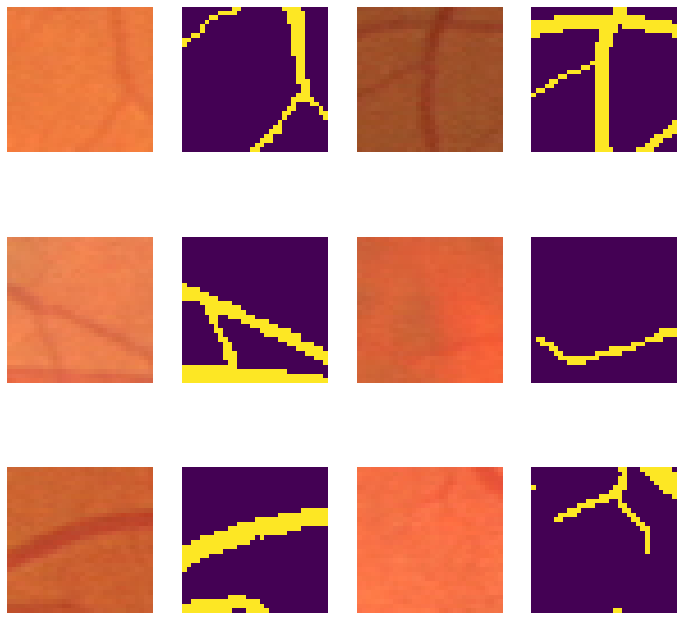

In [3]:
from unet_utils import extract_patches, preprocessing

# work with 32x32 patches
patch_size = (32, 32)

# 200 patches per image
patches_per_im = 200

# visualize a couple of patches as a visual check
patches, patches_segmentations = extract_patches(train_images, train_segmentations, patch_size, patches_per_im=1, seed=7)

print(patches.shape)

fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(12, 12))

for i in range(0, 3):
    axes[i, 0].axis('off')
    axes[i, 0].imshow(patches[i])
    axes[i, 1].axis('off')
    axes[i, 1].imshow(patches_segmentations[i][:, :, 0])
    axes[i, 2].axis('off')
    axes[i, 2].imshow(patches[i+5])
    axes[i, 3].axis('off')
    axes[i, 3].imshow(patches_segmentations[i+5][:, :, 0])

plt.show()

In [4]:
# pad the validation data to fit the U-Net model
# images of shape (584, 565) shape result in concatenation error due to the odd number of columns

print("Old shape:", val_images.shape)

val_images, val_masks, val_segmentations = preprocessing(
    val_images, 
    val_masks, 
    val_segmentations, 
    desired_shape=(584, 584))
    
print("New shape:", val_images.shape)

Old shape: (4, 584, 565, 3)
New shape: (4, 584, 584, 3)


In [5]:
import os
from unet_model import unet
from unet_utils import datagenerator
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# use a single training image, to better demonstrate the effects of data augmentation
X_train, y_train = np.expand_dims(train_images[0], axis=0), np.expand_dims(train_segmentations[0], axis=0)

print(X_train.shape)
print(y_train.shape)

# hyperparameters
depth = 3
channels = 32
use_batchnorm = True
batch_size = 64
epochs = 12
steps_per_epoch = int(np.ceil((patches_per_im * len(train_images)) / batch_size))

# work with 32x32 patches
patch_size = (32, 32)
# 200 patches per image
patches_per_im = 200

# initialize model
model = unet(input_shape=(None, None, 3), depth=depth, channels=channels, batchnorm=use_batchnorm)

# print a summary of the model
# model.summary(line_length=120)

# compile the model
model.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])

# stop the training if the validation loss does not increase for 15 consecutive epochs
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

# train the model with the data generator, and save the training history
history = model.fit_generator(datagenerator(X_train, y_train, patch_size, patches_per_im, batch_size),
                              validation_data=(val_images, val_segmentations),
                              steps_per_epoch=steps_per_epoch, epochs=epochs, verbose=2,
                              callbacks=[early_stopping])

(1, 584, 565, 3)
(1, 584, 565, 1)
Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
Train for 50 steps, validate on 4 samples
Epoch 1/12
50/50 - 63s - loss: 0.5558 - accuracy: 0.7947 - val_loss: 0.4689 - val_accuracy: 0.9211
Epoch 2/12
50/50 - 56s - loss: 0.3303 - accuracy: 0.9431 - val_loss: 0.2989 - val_accuracy: 0.9191
Epoch 3/12
50/50 - 58s - loss: 0.2406 - accuracy: 0.9538 - val_loss: 0.3417 - val_accuracy: 0.9182
Epoch 4/12
50/50 - 59s - loss: 0.1867 - accuracy: 0.9590 - val_loss: 0.3382 - val_accuracy: 0.8538
Epoch 5/12
50/50 - 72s - loss: 0.1545 - accuracy: 0.9597 - val_loss: 0.3274 - val_accuracy: 0.9191
Epoch 6/12
50/50 - 61s - loss: 0.1568 - accuracy: 0.9565 - val_loss: 0.3284 - val_accuracy: 0.9180
Epoch 7/12
50/50 - 58s - loss: 0.1354 - accuracy: 0.9608 - val_loss: 0.3389 - val_accuracy: 0.9207
Epoch 8/12
50/50 - 57s - loss: 0.1345 - accuracy: 0.9605 - val_loss: 0.3921 - val_accuracy: 0.9261
Epoch 9/12
50/50 - 59s - loss: 

### Visualizing the segmentation results

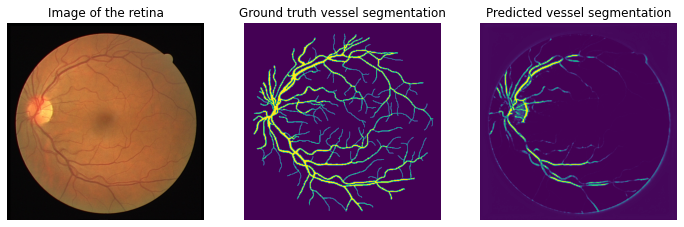

In [6]:
# run the model on one test image and show the results
from unet_utils import preprocessing

# test data paths
impaths_test = glob(data_folder + 'test/images/*.tif')

# load data
test_images, test_masks, test_segmentations = load_data(impaths_test, test=True)

# pad the data to fit the U-Net model
test_images, test_masks, test_segmentations = preprocessing(test_images, test_masks, test_segmentations, 
                                                            desired_shape=(584, 584))

# use a single image to evaluate
X_test, y_test = np.expand_dims(test_images[0], axis=0), np.expand_dims(test_masks[0], axis=0)

# predict test samples
test_prediction = model.predict(X_test, batch_size=4)

# visualize the test result
plt.figure(figsize=(12, 10))

plt.subplot(1, 3, 1)
plt.title("Image of the retina")
plt.axis('off')
plt.imshow(test_images[0])

plt.subplot(1, 3, 2)
plt.title("Ground truth vessel segmentation")
plt.axis('off')
plt.imshow(test_segmentations[0][:, :, 0])

plt.subplot(1, 3, 3)
plt.title("Predicted vessel segmentation")
plt.axis('off')
plt.imshow(test_prediction[0, :, :, 0])

plt.show()

# Exercises

## Number of parameters

The first convolutional layer in the MNIST example has 320 parameters. The first fully connected layer has 1179,776 parameters. What do these parameters correspond to? 

<font color='#770a0a'>What is the general expression for the number of parameters of 1) a convolutional layer and 2) a fully-connected layer?</font>

## Fully-convolutional MNIST model

Modify the model in the MNIST example in such a way that it only contains convolutional layers while keeping the same number of parameters. If you do the modification correctly, the two models will have the same behaviour (i.e. they will represent the same model, only with different implementation). Show this experimentally.

### Answer:

A fully convolutional neural network can be made by replacing the dense layers with convolutional and max pooling layers. In the MNIST model, the dense layer with filter of 128 needs to be replaced with a convolutional layer with kernel size 12x12 combined with a max pooling layer of kernel size 12x12. Note that the final dense layer that includes the softmax activation does not need to be modified. The amount of parameters in the new model remains then the same. See the model summary of the new model below.  

In [9]:
# only convolutional layers, so no dense or fully connected layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense

model2 = Sequential()
model2.add(Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model2.add(Conv2D(64, (3, 3), activation='relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(Dropout(0.25))
model2.add(Conv2D(128, kernel_size = (12,12), padding = 'same', activation = 'relu'))
model2.add(MaxPooling2D(pool_size = (12,12)))
model2.add(Flatten())
model2.add(Dropout(0.5))
model2.add(Dense(10, activation='softmax'))

model2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 12, 12, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 12, 12, 128)       1179776   
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 1, 1, 128)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 128)              

The new model can also be trained and evaluated on its performance with the test data. The test loss and accuracy of the two models should be close to each other. This is the case as can be seen below. 

In [10]:
# compiling and training the model

from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adam

model2.compile(loss=categorical_crossentropy, optimizer=Adam(), metrics=['accuracy'])

model2.fit(x_train, y_train,
          batch_size=128,
          epochs=12,
          verbose=1,
          validation_data=(x_test, y_test))

Epoch 1/12
469/469 [==============================] - 35s 70ms/step - loss: 0.5722 - accuracy: 0.8073 - val_loss: 0.0497 - val_accuracy: 0.9834
Epoch 2/12
469/469 [==============================] - 32s 68ms/step - loss: 0.0904 - accuracy: 0.9727 - val_loss: 0.0269 - val_accuracy: 0.9903
Epoch 3/12
469/469 [==============================] - 31s 66ms/step - loss: 0.0613 - accuracy: 0.9807 - val_loss: 0.0246 - val_accuracy: 0.9917TA: 23s - loss: 0.063 - ETA:  - ETA: 19s - loss: 0.062 - ETA: 18s - loss: 0.0627 - ETA: 17s - loss: 0.0626 - accurac - ETA: 16s - loss: 0.0 - ETA: 15s - loss: 0.0624 -  - ETA: 11s - l - ETA: 9s - loss: 0.0 - ETA: 2s - E
Epoch 4/12
469/469 [==============================] - 32s 68ms/step - loss: 0.0499 - accuracy: 0.9847 - val_loss: 0.0216 - val_accuracy: 0.9927
Epoch 5/12
469/469 [==============================] - 32s 68ms/step - loss: 0.0433 - accuracy: 0.9872 - val_loss: 0.0213 - val_accuracy: 0.9928
Epoch 6/12
469/469 [==============================] - 31s 67m

In [11]:
# evaluation of model on independent test set 

score = model2.evaluate(x_test, y_test, verbose=0)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.018244195729494095
Test accuracy: 0.9947999715805054


The advantage of using a fully convolutional neural network instead of a convolutional neural network is that the spatial information is retained. This spatial information can be used to understand more from an image besides classification. 

## U-Net architecture

<font color='#770a0a'> What is the role of the skip connections in the U-Net neural network architecture? Will it be possible to train the exact same architecture with the skip connections omitted? If yes, what would be the expected result? If no, what would be the cause of the error?</font>

**Answer**: 
The U-net neural network architecture is an symmetrical architecture consisting of an encoder and decoder part which are connected via long skip connections. In the encoder part  the spatial dimensionality is reduced followed by a gradual increase in the decoder part. The features are passed from the encoder to the decoder part using the skip connections to recover spatial information lost during downsampling. In U-net the skip connections use concatenation of the features. The skip connections allow for the fine-grained details learned in the encoder part to be recoverd in the decoder part to construct an image. 

It is possible to train the neural network without the skip connections if the dimensions of filter kernels are changed. In the absence of the skip connections the number of feature maps in te encoder steps will be lower as there is no concatenation of the feature maps from the skip connections. It is not possible to train the neural network if the filter kernels are not changed as this will result in a matrix dimension error.

## Data augmentation

<font color='#770a0a'>Why does data augmentation result in less overfitting? Can data augmentation be applied to the test samples? If yes, towards what goal? If no, what is preventing that?</font>

**Answer Q1**: The model has a feature less to train on, namely the image intensity. When the model is less complex, and thus has less features, it results in less overfitting.

**Answer Q2**: Image augmentation helps the model be more generalised and robust and is usually only done on the training data. Test data augmentation is only done when you want to do test-time augmentation to obtain a lower variance in your results. this is however an exception and is not often done.

Implement random brightness augmentation of the image data by adding a random offset to the image intensity before passing them trough the network at training time. Train a model with random brightness augmentation and compare it to the baseline above. 

Implement data augmentation procedure that in addition to brightness augmentation also performs b-spline geometric augmentation using the [`gryds`](https://github.com/tueimage/gryds) package (you can look at the documentation of the package for an example on how to do that). Compare the new model with the baseline and the model that only performs brightness augmentation.

### Data augmentation random intensity

Data agumentation with random intensity

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


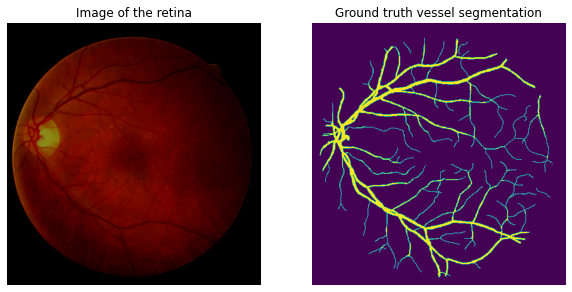

(16, 584, 565, 3)
(16, 584, 565, 1)
(16, 584, 565, 1)
(4, 584, 565, 3)
(4, 584, 565, 1)
(4, 584, 565, 1)


In [7]:
#trained model with random brightness
import tensorflow as tf

random_images = np.empty([20,584,565,3])
for i in range(len(images)):
    random_images[i] = np.asarray((tf.image.random_brightness(images[i], 0.7)))

plt.figure(figsize=(10, 8))

plt.subplot(1, 2, 1)
plt.title("Image of the retina")
plt.axis('off')
plt.imshow(random_images[0])

plt.subplot(1, 2, 2)
plt.title("Ground truth vessel segmentation")
plt.axis('off')
plt.imshow(segmentations[0][:, :, 0])
plt.show()

# divide in training and validation
train_images, val_images, train_masks, val_masks, train_segmentations, val_segmentations = train_test_split(
    random_images, masks, segmentations, test_size=0.2, random_state=7)

# print the shape of the training and valudation datasets
print(train_images.shape)
print(train_masks.shape)
print(train_segmentations.shape)
print(val_images.shape)
print(val_masks.shape)
print(val_segmentations.shape)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(16, 32, 32, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


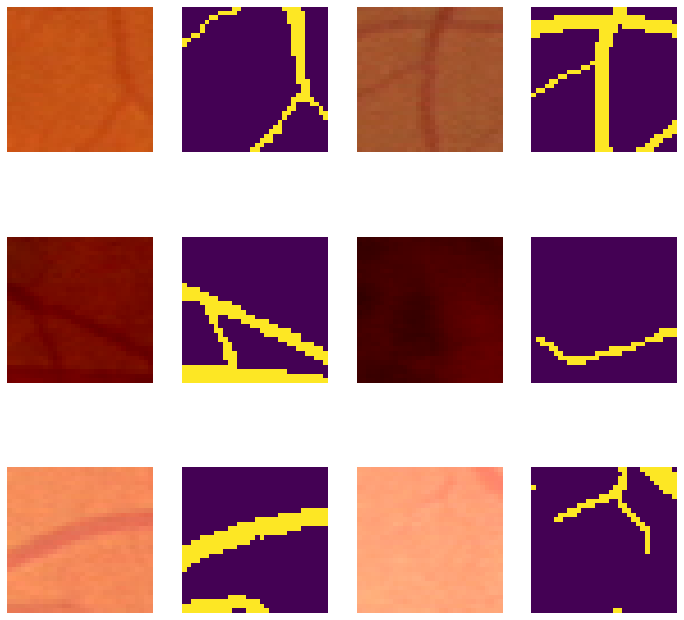

In [8]:
from unet_utils import extract_patches, preprocessing

# work with 32x32 patches
patch_size = (32, 32)

# 200 patches per image
patches_per_im = 200

# visualize a couple of patches as a visual check
patches, patches_segmentations = extract_patches(train_images, train_segmentations, patch_size, patches_per_im=1, seed=7)

print(patches.shape)

fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(12, 12))

for i in range(0, 3):
    axes[i, 0].axis('off')
    axes[i, 0].imshow(patches[i])
    axes[i, 1].axis('off')
    axes[i, 1].imshow(patches_segmentations[i][:, :, 0])
    axes[i, 2].axis('off')
    axes[i, 2].imshow(patches[i+5])
    axes[i, 3].axis('off')
    axes[i, 3].imshow(patches_segmentations[i+5][:, :, 0])

plt.show()

In [9]:
# pad the validation data to fit the U-Net model
# images of shape (584, 565) shape result in concatenation error due to the odd number of columns

print("Old shape:", val_images.shape)

val_images, val_masks, val_segmentations = preprocessing(
    val_images, 
    val_masks, 
    val_segmentations, 
    desired_shape=(584, 584))
    
print("New shape:", val_images.shape)

Old shape: (4, 584, 565, 3)
New shape: (4, 584, 584, 3)


In [10]:
# use a single training image, to better demonstrate the effects of data augmentation
X_train, y_train = np.expand_dims(train_images[0], axis=0), np.expand_dims(train_segmentations[0], axis=0)

print(X_train.shape)
print(y_train.shape)

# hyperparameters
depth = 3
channels = 32
use_batchnorm = True
batch_size = 64
epochs = 12
steps_per_epoch = int(np.ceil((patches_per_im * len(train_images)) / batch_size))

# work with 32x32 patches
patch_size = (32, 32)
# 200 patches per image
patches_per_im = 200

# initialize model
model = unet(input_shape=(None, None, 3), depth=depth, channels=channels, batchnorm=use_batchnorm)

# print a summary of the model
# model.summary(line_length=120)

# compile the model
model.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])

# stop the training if the validation loss does not increase for 15 consecutive epochs
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

# train the model with the data generator, and save the training history
history = model.fit_generator(datagenerator(X_train, y_train, patch_size, patches_per_im, batch_size),
                              validation_data=(val_images, val_segmentations),
                              steps_per_epoch=steps_per_epoch, epochs=epochs, verbose=2,
                              callbacks=[early_stopping])

(1, 584, 565, 3)
(1, 584, 565, 1)
  ...
    to  
  ['...']
Train for 50 steps, validate on 4 samples
Epoch 1/12
50/50 - 69s - loss: 0.4386 - accuracy: 0.8895 - val_loss: 0.3909 - val_accuracy: 0.9211
Epoch 2/12
50/50 - 59s - loss: 0.2826 - accuracy: 0.9539 - val_loss: 0.2925 - val_accuracy: 0.9211
Epoch 3/12
50/50 - 53s - loss: 0.2007 - accuracy: 0.9575 - val_loss: 0.2880 - val_accuracy: 0.9211
Epoch 4/12
50/50 - 48s - loss: 0.2427 - accuracy: 0.9512 - val_loss: 1.2789 - val_accuracy: 0.8035
Epoch 5/12
50/50 - 54s - loss: 0.1869 - accuracy: 0.9546 - val_loss: 0.3102 - val_accuracy: 0.9206
Epoch 6/12
50/50 - 50s - loss: 0.1553 - accuracy: 0.9567 - val_loss: 0.2973 - val_accuracy: 0.9211
Epoch 7/12
50/50 - 55s - loss: 0.1398 - accuracy: 0.9604 - val_loss: 0.2962 - val_accuracy: 0.9171
Epoch 8/12
50/50 - 50s - loss: 0.1308 - accuracy: 0.9593 - val_loss: 0.2724 - val_accuracy: 0.9174
Epoch 9/12
50/50 - 48s - loss: 0.1189 - accuracy: 0.9634 - val_loss: 0.2989 - val_accuracy: 0.9156
Epoch 10

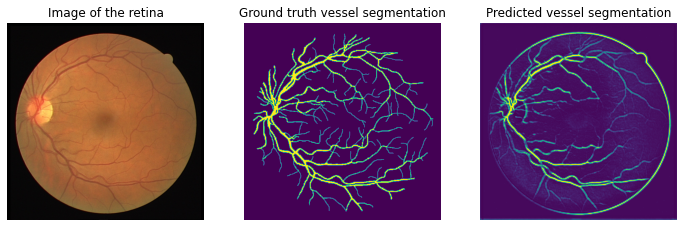

In [11]:
# test data paths
impaths_test = glob(data_folder + 'test/images/*.tif')

# load data
test_images, test_masks, test_segmentations = load_data(impaths_test, test=True)

# pad the data to fit the U-Net model
test_images, test_masks, test_segmentations = preprocessing(test_images, test_masks, test_segmentations, 
                                                            desired_shape=(584, 584))

# use a single image to evaluate
X_test, y_test = np.expand_dims(test_images[0], axis=0), np.expand_dims(test_masks[0], axis=0)

# predict test samples
test_prediction = model.predict(X_test, batch_size=4)

# visualize the test result
plt.figure(figsize=(12, 10))

plt.subplot(1, 3, 1)
plt.title("Image of the retina")
plt.axis('off')
plt.imshow(test_images[0])

plt.subplot(1, 3, 2)
plt.title("Ground truth vessel segmentation")
plt.axis('off')
plt.imshow(test_segmentations[0][:, :, 0])

plt.subplot(1, 3, 3)
plt.title("Predicted vessel segmentation")
plt.axis('off')
plt.imshow(test_prediction[0, :, :, 0])

plt.show()

### Data augmentation b-spline

Data agumentation with random intensity and b-spline

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


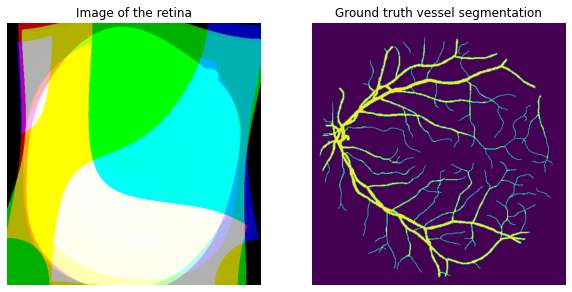

(16, 584, 565, 3)
(16, 584, 565, 1)
(16, 584, 565, 1)
(4, 584, 565, 3)
(4, 584, 565, 1)
(4, 584, 565, 1)


In [17]:
#trained model with random brightness
import tensorflow as tf
import gryds

random_images = np.empty([20,584,565,3])
for i in range(len(images)):
    random_images[i] = np.asarray((tf.image.random_brightness(images[i], 0.7)))


transformed_images = np.empty([20,584,565,3])

for i in range(len(images)):
    random_grid = np.random.rand(3, 3, 3, 3)
    random_grid -= 0.5
    random_grid /= 5
    bspline = gryds.BSplineTransformation(random_grid)
    bspline_images = gryds.Interpolator(random_images[i])
    transformed_images[i] = bspline_images.transform(bspline)

    
plt.figure(figsize=(10, 8))

plt.subplot(1, 2, 1)
plt.title("Image of the retina")
plt.axis('off')
plt.imshow(transformed_images[0])

plt.subplot(1, 2, 2)
plt.title("Ground truth vessel segmentation")
plt.axis('off')
plt.imshow(segmentations[0][:, :, 0])

plt.show()

# divide in training and validation
train_images, val_images, train_masks, val_masks, train_segmentations, val_segmentations = train_test_split(
    transformed_images, masks, segmentations, test_size=0.2, random_state=7)

# print the shape of the training and valudation datasets
print(train_images.shape)
print(train_masks.shape)
print(train_segmentations.shape)
print(val_images.shape)
print(val_masks.shape)
print(val_segmentations.shape)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(16, 32, 32, 3)


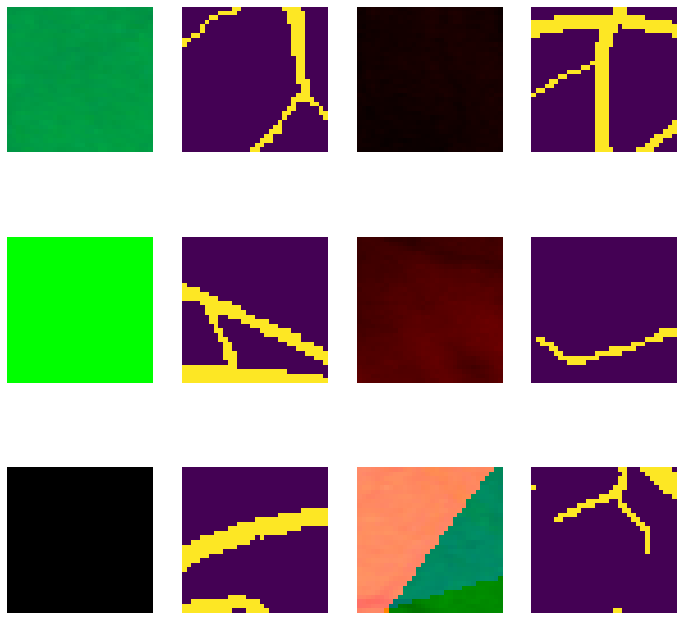

In [18]:
from unet_utils import extract_patches, preprocessing

# work with 32x32 patches
patch_size = (32, 32)

# 200 patches per image
patches_per_im = 200

# visualize a couple of patches as a visual check
patches, patches_segmentations = extract_patches(train_images, train_segmentations, patch_size, patches_per_im=1, seed=7)

print(patches.shape)

fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(12, 12))

for i in range(0, 3):
    axes[i, 0].axis('off')
    axes[i, 0].imshow(patches[i])
    axes[i, 1].axis('off')
    axes[i, 1].imshow(patches_segmentations[i][:, :, 0])
    axes[i, 2].axis('off')
    axes[i, 2].imshow(patches[i+5])
    axes[i, 3].axis('off')
    axes[i, 3].imshow(patches_segmentations[i+5][:, :, 0])

plt.show()

In [19]:
# pad the validation data to fit the U-Net model
# images of shape (584, 565) shape result in concatenation error due to the odd number of columns

print("Old shape:", val_images.shape)

val_images, val_masks, val_segmentations = preprocessing(
    val_images, 
    val_masks, 
    val_segmentations, 
    desired_shape=(584, 584))
    
print("New shape:", val_images.shape)

Old shape: (4, 584, 565, 3)
New shape: (4, 584, 584, 3)


In [20]:
# use a single training image, to better demonstrate the effects of data augmentation
X_train, y_train = np.expand_dims(train_images[0], axis=0), np.expand_dims(train_segmentations[0], axis=0)

print(X_train.shape)
print(y_train.shape)

# hyperparameters
depth = 3
channels = 32
use_batchnorm = True
batch_size = 64
epochs = 12
steps_per_epoch = int(np.ceil((patches_per_im * len(train_images)) / batch_size))

# work with 32x32 patches
patch_size = (32, 32)
# 200 patches per image
patches_per_im = 200

# initialize model
model = unet(input_shape=(None, None, 3), depth=depth, channels=channels, batchnorm=use_batchnorm)

# print a summary of the model
# model.summary(line_length=120)

# compile the model
model.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])

# stop the training if the validation loss does not increase for 15 consecutive epochs
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

# train the model with the data generator, and save the training history
history = model.fit_generator(datagenerator(X_train, y_train, patch_size, patches_per_im, batch_size),
                              validation_data=(val_images, val_segmentations),
                              steps_per_epoch=steps_per_epoch, epochs=epochs, verbose=2,
                              callbacks=[early_stopping])

(1, 584, 565, 3)
(1, 584, 565, 1)
  ...
    to  
  ['...']
Train for 50 steps, validate on 4 samples
Epoch 1/12
50/50 - 53s - loss: 0.6360 - accuracy: 0.7049 - val_loss: 0.5433 - val_accuracy: 0.9211
Epoch 2/12
50/50 - 47s - loss: 0.4864 - accuracy: 0.8856 - val_loss: 0.4322 - val_accuracy: 0.9211
Epoch 3/12
50/50 - 48s - loss: 0.3789 - accuracy: 0.9069 - val_loss: 0.3382 - val_accuracy: 0.9203
Epoch 4/12
50/50 - 47s - loss: 0.3207 - accuracy: 0.9059 - val_loss: 0.4009 - val_accuracy: 0.9211
Epoch 5/12
50/50 - 49s - loss: 0.2932 - accuracy: 0.9071 - val_loss: 0.3586 - val_accuracy: 0.8686
Epoch 6/12
50/50 - 48s - loss: 0.2826 - accuracy: 0.9080 - val_loss: 0.6977 - val_accuracy: 0.7846
Epoch 7/12
50/50 - 49s - loss: 0.2699 - accuracy: 0.9099 - val_loss: 0.4189 - val_accuracy: 0.8668
Epoch 8/12
50/50 - 47s - loss: 0.2788 - accuracy: 0.9057 - val_loss: 1.0307 - val_accuracy: 0.8752
Epoch 9/12
50/50 - 48s - loss: 0.2906 - accuracy: 0.9023 - val_loss: 0.7038 - val_accuracy: 0.8583
Epoch 10

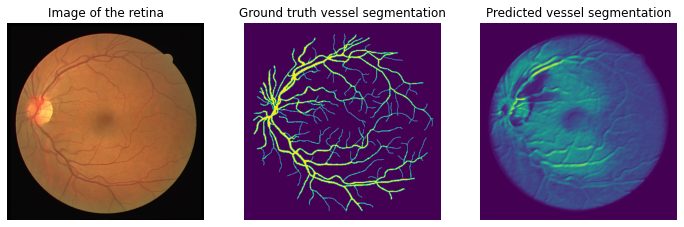

In [21]:
# test data paths
impaths_test = glob(data_folder + 'test/images/*.tif')

# load data
test_images, test_masks, test_segmentations = load_data(impaths_test, test=True)

# pad the data to fit the U-Net model
test_images, test_masks, test_segmentations = preprocessing(test_images, test_masks, test_segmentations, 
                                                            desired_shape=(584, 584))

# use a single image to evaluate
X_test, y_test = np.expand_dims(test_images[0], axis=0), np.expand_dims(test_masks[0], axis=0)

# predict test samples
test_prediction = model.predict(X_test, batch_size=4)

# visualize the test result
plt.figure(figsize=(12, 10))

plt.subplot(1, 3, 1)
plt.title("Image of the retina")
plt.axis('off')
plt.imshow(test_images[0])

plt.subplot(1, 3, 2)
plt.title("Ground truth vessel segmentation")
plt.axis('off')
plt.imshow(test_segmentations[0][:, :, 0])

plt.subplot(1, 3, 3)
plt.title("Predicted vessel segmentation")
plt.axis('off')
plt.imshow(test_prediction[0, :, :, 0])

plt.show()